**Full Name: Hamidreza Amirzadeh**

**Student Number: 401206999**


# Denoising Autoencoder
In this notebook, you are going to build and train a denoising autoencoder. The purpose of an autoencoder, a form of neural network, is to develop codings for data. 

An autoencoder has two parts: an encoder and a decoder. The encoder modifies the input data and produces a representation for the input in a smaller dimension, and the decoding function reconstructs the input data from the encoded representation. 

A denoising autoencoder is an autoencoder that gets noisy data as input and tries to produce the denoised output for that input.

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## Preparing the data
You'll use [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset to train your DAE.

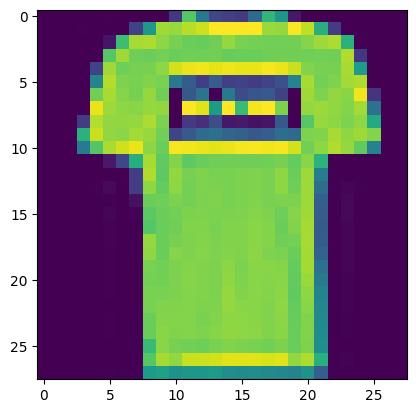

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [12]:
fm_train_set = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
fm_test_set = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# For both the `fm_train_set` and `fm_test_set` only keep the 
# images and leave out the labels.
# Also, normalize the values to be between [0, 1].
##############################
# Your code goes here (5 points)
train_imgs = torch.stack([x[0][0] for x in fm_train_set])
test_imgs = torch.stack([x[0][0] for x in fm_test_set])
##############################

plt.imshow(train_imgs[1].unsqueeze(0).permute(1, 2, 0))
plt.show()
print(train_imgs.shape, test_imgs.shape)

In [19]:
import random

def add_noise(img):
    noisy_img = img.clone()
    num_pixels = int(0.2 * img.shape[0] * img.shape[1]) # Set 20% of the pixels to 0 or 1
    indices = [(i, j) for i in range(img.shape[0]) for j in range(img.shape[1])]
    chosen_indices = random.sample(indices, num_pixels)
    for i, j in chosen_indices:
      if random.random() < 0.5:
        noisy_img[i, j] = 0.0
      else:
        noisy_img[i, j] = 1.0
    return noisy_img

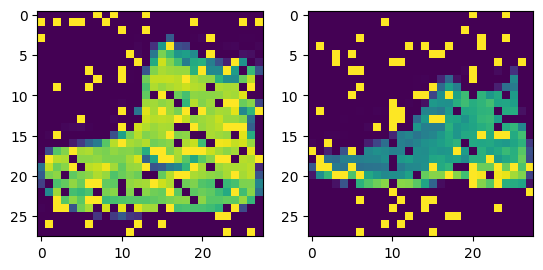

In [20]:
# For each image in our training and test sets,
# create a noisy version of the image.
# We'll use these noisy images as input data for the
# dataset we're going to create. The labels of this dataset
# would be the original images.
##############################
# Your code goes here (10 points)
noisy_train_imgs = torch.stack([add_noise(img) for img in train_imgs])
noisy_test_imgs = torch.stack([add_noise(img) for img in test_imgs])
##############################
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(noisy_train_imgs[0])
f.add_subplot(1, 2, 2)
plt.imshow(noisy_test_imgs[0])
plt.show()

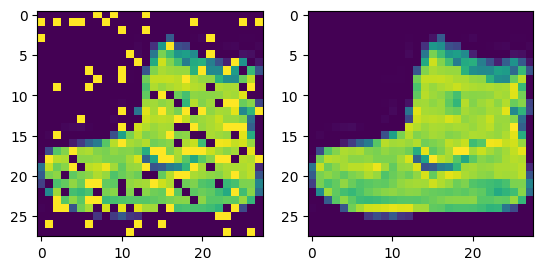

In [31]:
# Now we want to construct our new training and test sets.
# To do so, you'll use the noisy images you've created for each set
# as input for the new dataset and the original Fashion MNIST images as labels.

# Construct `training_set` (data, label) pairs.
##############################
# Your code goes here (10 points)
train_set = list(zip(noisy_train_imgs, train_imgs))
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(train_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(train_set[0][1])
plt.show()

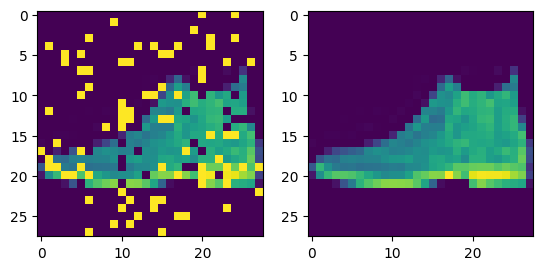

In [33]:
# Construct `test_set` (data, label) pairs.
##############################
# Your code goes here (5 points)
test_set = list(zip(noisy_test_imgs, test_imgs))
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(test_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(test_set[0][1])
plt.show()

In [34]:
# Finally, create DataLoaders for the datasets.
# Use a batch size of 128 and enable shuffling.
##############################
# Your code goes here (5 points)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)
##############################

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fe3819bfee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe3819bf760>)

## Creating the Model


In this part, you're going to create the DAE model.

In [87]:
# The encoder takes the input and outputs the `encoded representation`.
# Create the encoder using nn.Sequential (You can use the architecture 
# shown in this cell's output).
# Use Conv2d layers followed by ReLU.
# After conv2d layers, flatten the data and use linear layers to
# smoothly transform the output from conv2d layers into the encoded space.
# Set the encoded space dimensions to 10 * 1.
##############################
# Your code goes here (15 points)
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, (3,3), (2,2), (1,1)),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, (3,3), (2,2), (1,1)),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 32, (3,3), (2,2)),
        nn.ReLU(inplace=True),
        nn.Flatten(),
        nn.Linear(288, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    out = self.encoder(x)
    return out
##############################
encoder = Encoder()
encoder

Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=288, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [88]:
# The decoder takes the encoded data generated by the encoder
# and outputs the original input.
# Create the decoder using nn.Sequential.
# Reverse the operations used in encoder.
##############################
# Your code goes here (15 points)
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 288),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (32, 3, 3)),
            nn.ConvTranspose2d(32, 16, (3,3), (2,2)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 8, (3,3), (2,2), (1,1), (1,1)),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, (3,3), (2,2), (1,1), (1,1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.decoder(x)
        return out
##############################
decoder = Decoder()
decoder

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=288, bias=True)
    (5): ReLU(inplace=True)
    (6): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (14): Sigmoid()
  )
)

Now we can construct the DAE by sequentially connecting the `encoder` and `decoder` networks.

In [89]:
DAE = nn.Sequential(encoder, decoder).to(device=device)

## Training the DAE

### Visualizing the Latent Space

During the training, we intend to visualize the *encoded representations* learned by the DAE every 10 epochs. You are going to use T-SNE for this purpose. In order to do so, you have to pass the selected samples to the encoder and retrieve the encoded vectors. Then you can visualize these vectors on a plane and colorize the points according to the class of object each represent.

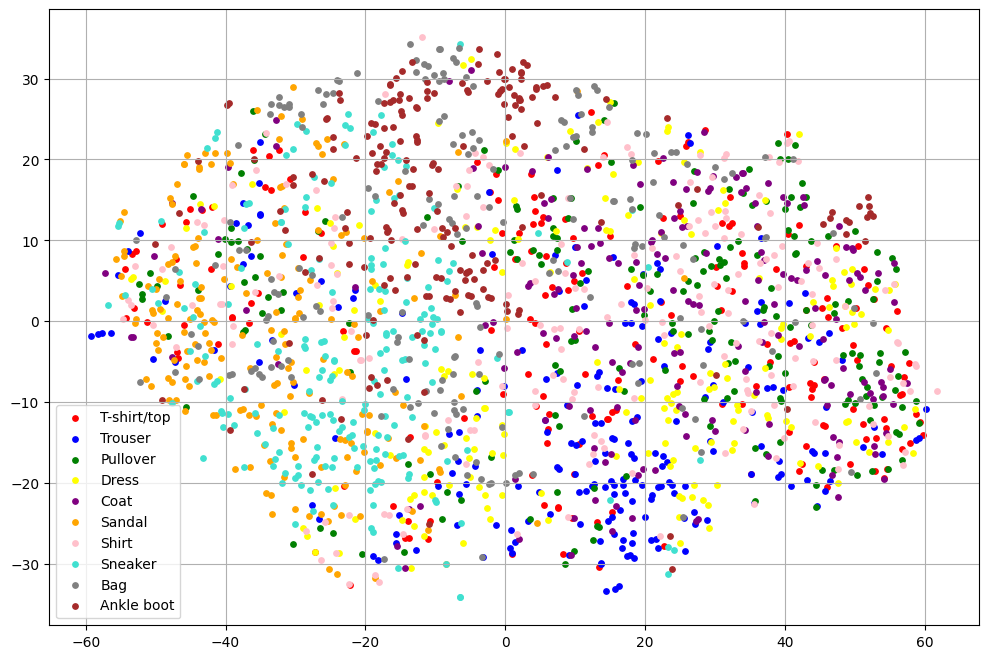

In [90]:
from sklearn.manifold import TSNE

noisy_imgs = noisy_train_imgs[:2000]
noisy_imgs_classes = torch.tensor([x[1] for x in fm_train_set])[:2000]

def visualize():
  # Plot the encoded representations of the first 2000
  # images from `fm_train_set` on a plane.
  # You must first pass the images to
  # the encoder to get the encoded vectors, and then you
  # must transform these vectors to 2D space using TSNE
  # and plot the points.
  ##############################
  # Your code goes here (15 points)
  encoder.to(device)
  encoder.eval()
  with torch.no_grad():
    encoded = encoder(noisy_imgs.unsqueeze(1).to(device)).detach().cpu()
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(encoded)
    x1 = [point[0] for point in embeddings]
    x2 = [point[1] for point in embeddings]

    colors = ['Red', 'Blue', 'green', 'Yellow', 'purple', 'Orange', 'pink', 'Turquoise', 'Gray', 'Brown']

    plt.figure(figsize=(12, 8))
    for i in range(10):
      filter = np.array(noisy_imgs_classes==i)
      x1_i = np.array(x1)[filter]
      x2_i = np.array(x2)[filter]
      labels_i = np.array(noisy_imgs_classes)[filter]
      plt.scatter(x1_i, x2_i, c=colors[i], s=15, label=fm_train_set.classes[i])

    plt.legend(fontsize=10)
    plt.grid()
    plt.show()
  ##############################

# Testing the function
visualize()

In [91]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()
        for imgs, labels in train_loader:
            # Compute the output.
            # Use GPU for your data if possible.
            ##############################
            # Your code goes here (5 points)
            imgs, labels = imgs.to(device), labels.to(device)
            recon_imgs = model(imgs.unsqueeze(1)).squeeze(1)
            ##############################

            # Using `loss_fn` and `optimizer`, compute the loss and do the backprop step.
            ##############################
            # Your code goes here (5 points)
            loss = loss_fn(recon_imgs, labels)
            loss_train += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##############################
            
        print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        # Every 10 epochs, we visualize the encoded representations.
        if epoch % 10 == 0:
          visualize()

Epoch 1, Training loss 0.04848448378540306
Epoch 2, Training loss 0.021352520486566304
Epoch 3, Training loss 0.01912054608959252
Epoch 4, Training loss 0.017990519930082344
Epoch 5, Training loss 0.01724897978553322
Epoch 6, Training loss 0.016673956858689217
Epoch 7, Training loss 0.01624814852047513
Epoch 8, Training loss 0.015908611793396695
Epoch 9, Training loss 0.015591460530326437
Epoch 10, Training loss 0.015308627999747105


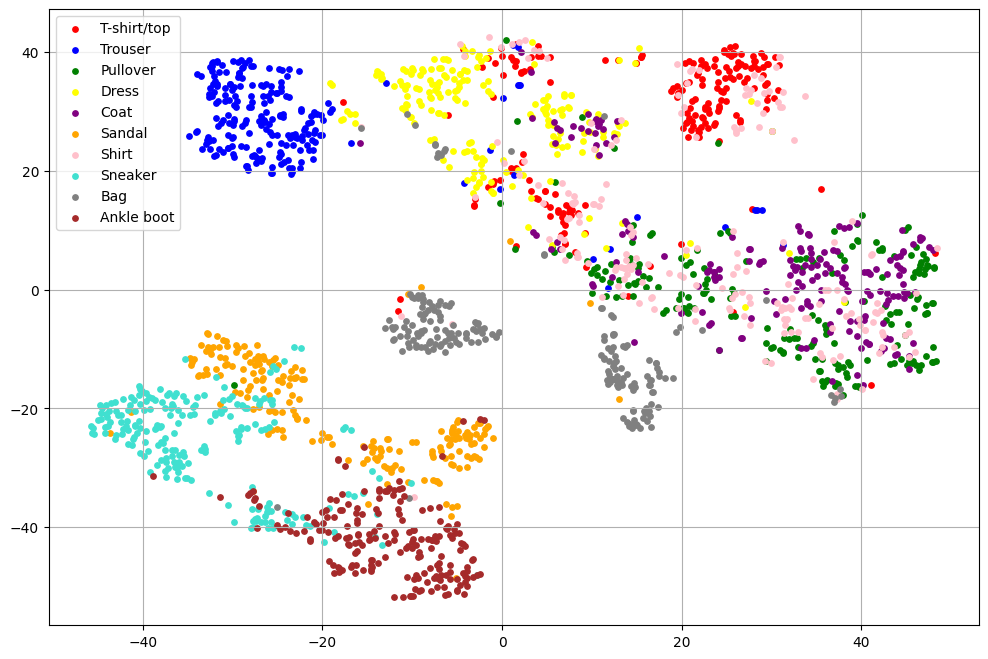

Epoch 11, Training loss 0.015063283839888537
Epoch 12, Training loss 0.014906784825360597
Epoch 13, Training loss 0.014777784299319868
Epoch 14, Training loss 0.014630329739580403
Epoch 15, Training loss 0.014498618351958835
Epoch 16, Training loss 0.014367526548026975
Epoch 17, Training loss 0.014339481923244655
Epoch 18, Training loss 0.014219748418230111
Epoch 19, Training loss 0.014097754174331104
Epoch 20, Training loss 0.014062161678507892


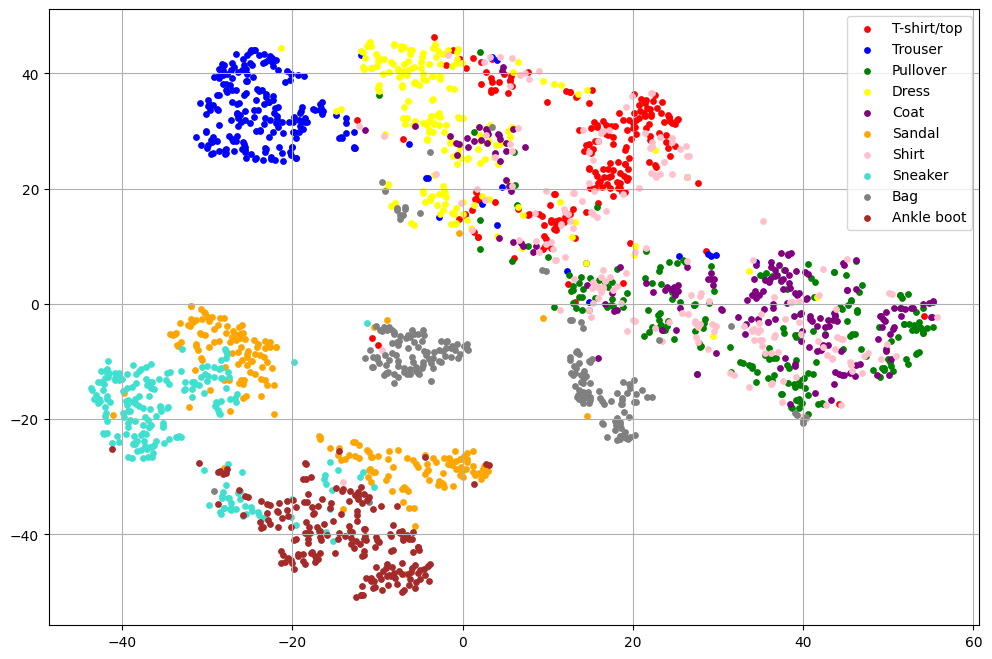

In [92]:
epochs = 20
# Train the DAE. use MSE as the loss function and 
# use Adam for the optimizer. Set the learning rate to 1e-3.
##############################
# Your code goes here (5 points)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DAE.parameters(), lr=1e-3)

train(epochs, optimizer, DAE, criterion, train_loader)
##############################

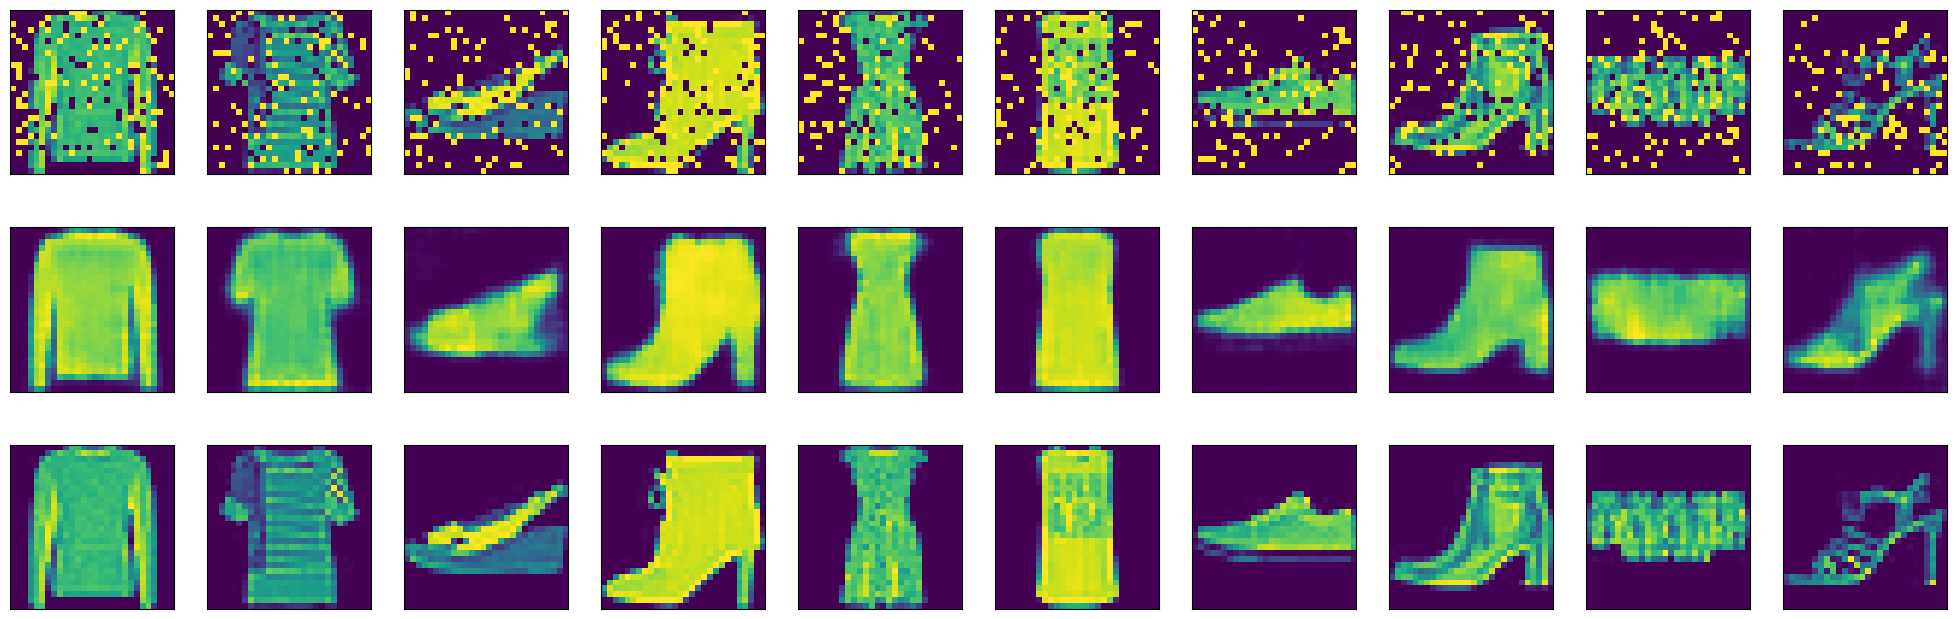

In [151]:
# Use 10 examples from the testing set to evaluate the 
# DAE's outputs visually.
##############################
# Your code goes here (5 points)
random_idx = torch.randint(len(noisy_test_imgs), (10,))
noisy_test_imgs_sample = noisy_test_imgs[random_idx]
test_imgs_sample = test_imgs[random_idx]
noisy_test_imgs_sample_recon = DAE(noisy_test_imgs_sample.unsqueeze(1).to(device)).squeeze(1)


fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,8))

# input noisy images on top row, reconstructions on middle, original clean images on bottom
for noisy_imgs, row in zip([noisy_test_imgs_sample, noisy_test_imgs_sample_recon, test_imgs_sample], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img.detach().cpu()))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
##############################